In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import time
import datetime

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

from nltk.tokenize import RegexpTokenizer 
from nltk.stem import PorterStemmer
from wordcloud import WordCloud, STOPWORDS

from sklearn.feature_extraction.text import TfidfVectorizer
import pickle
import warnings
warnings.filterwarnings('ignore')

## 1. Collecting Phishing URLs

In [3]:
phish = pd.read_csv('2.online-valid.csv')
phish.head()

,phish_id,url,phish_detail_url,submission_time,verified,verification_time,online,target
0,6557033,http://u1047531.cp.regruhosting.ru/acces-inges...,http://www.phishtank.com/phish_detail.php?phis...,2020-05-09T22:01:43+00:00,yes,2020-05-09T22:03:07+00:00,yes,Other
1,6557032,http://hoysalacreations.com/wp-content/plugins...,http://www.phishtank.com/phish_detail.php?phis...,2020-05-09T22:01:37+00:00,yes,2020-05-09T22:03:07+00:00,yes,Other
2,6557011,http://www.accsystemprblemhelp.site/checkpoint...,http://www.phishtank.com/phish_detail.php?phis...,2020-05-09T21:54:31+00:00,yes,2020-05-09T21:55:38+00:00,yes,Facebook
3,6557010,http://www.accsystemprblemhelp.site/login_atte...,http://www.phishtank.com/phish_detail.php?phis...,2020-05-09T21:53:48+00:00,yes,2020-05-09T21:54:34+00:00,yes,Facebook
4,6557009,https://firebasestorage.googleapis.com/v0/b/so...,http://www.phishtank.com/phish_detail.php?phis...,2020-05-09T21:49:27+00:00,yes,2020-05-09T21:51:24+00:00,yes,Microsoft


In [4]:
phish.shape

(14858, 8)

In [5]:
#Collecting 14,000 Phishing URLs randomly
phishurl = phish.sample(n = 14858, random_state = 12).copy()
phishurl = phishurl.reset_index(drop=True)
phishurl.head()

,phish_id,url,phish_detail_url,submission_time,verified,verification_time,online,target
0,6514946,http://confirmprofileaccount.com/,http://www.phishtank.com/phish_detail.php?phis...,2020-04-19T11:06:55+00:00,yes,2020-04-19T13:42:41+00:00,yes,Other
1,4927651,http://www.marreme.com/MasterAdmin/04mop.html,http://www.phishtank.com/phish_detail.php?phis...,2017-04-04T19:35:54+00:00,yes,2017-05-03T23:00:42+00:00,yes,Other
2,5116976,http://modsecpaststudents.com/review/,http://www.phishtank.com/phish_detail.php?phis...,2017-07-25T18:48:30+00:00,yes,2017-07-28T16:01:36+00:00,yes,Other
3,6356131,https://docs.google.com/forms/d/e/1FAIpQLScL6L...,http://www.phishtank.com/phish_detail.php?phis...,2020-01-13T20:13:37+00:00,yes,2020-01-17T01:55:38+00:00,yes,Other
4,6535965,https://oportunidadedasemana.com/americanas//?...,http://www.phishtank.com/phish_detail.php?phis...,2020-04-29T00:01:03+00:00,yes,2020-05-01T10:55:35+00:00,yes,Other


In [6]:
phishurl.shape

(14858, 8)

We have collected 14858 phishing URLs from the data

## 2. Collecting Legitimate URLs

In [7]:
#Loading legitimate files 
data1 = pd.read_csv("1.Benign_list_big_final.csv")
data1.columns = ['URLs']
data1.head()

,URLs
0,http://1337x.to/torrent/1110018/Blackhat-2015-...
1,http://1337x.to/torrent/1122940/Blackhat-2015-...
2,http://1337x.to/torrent/1124395/Fast-and-Furio...
3,http://1337x.to/torrent/1145504/Avengers-Age-o...
4,http://1337x.to/torrent/1160078/Avengers-age-o...


In [8]:
data1.shape

(35377, 1)

In [9]:
#Collecting 5,000 Legitimate URLs randomly
legiurl = data1.sample(n = 21858, random_state = 12).copy()
legiurl = legiurl.reset_index(drop=True)
legiurl.head()

,URLs
0,http://graphicriver.net/search?date=this-month...
1,http://ecnavi.jp/redirect/?url=http://www.cros...
2,https://hubpages.com/signin?explain=follow+Hub...
3,http://extratorrent.cc/torrent/4190536/AOMEI+B...
4,http://icicibank.com/Personal-Banking/offers/o...


In [10]:
legiurl.shape

(21858, 1)

# Feature Extraction

In this step, features are extracted from the URLs dataset.
The extracted features are categorized into
Address Bar based Features
Domain based Features
HTML & Javascript based Features

###  1. Address Bar Based Features:
Many features can be extracted that can be consided as address bar base features. Out of them, below mentioned were considered for this project.
1. Domain of URL
2. IP Address in URL
3. "@" Symbol in URL
4. Length of URL
5. Depth of URL
6. Redirection "//" in URL
7. "http/https" in Domain name
8. Using URL Shortening Services “TinyURL”
9. Prefix or Suffix "-" in Domain

Each of these features are explained and the coded below:

In [11]:
from urllib.parse import urlparse,urlencode
import ipaddress
import re

###  Domain of the URL
Here, we are just extracting the domain present in the URL. This feature doesn't have much significance in the training. May even be dropped while training the model.

In [12]:
def getDomain(url):  
  domain = urlparse(url).netloc
  if re.match(r"^www.",domain):
	       domain = domain.replace("www.","")
  return domain

###  IP Address in the URL
Checks for the presence of IP address in the URL. URLs may have IP address instead of domain name. If an IP address is used as an alternative of the domain name in the URL, we can be sure that someone is trying to steal personal information with this URL.
If the domain part of URL has IP address, the value assigned to this feature is 1 (phishing) or else 0 (legitimate)

In [13]:
def havingIP(url):
  try:
    ipaddress.ip_address(url)
    ip = 1
  except:
    ip = 0
  return ip

### "@" Symbol in URL
Checks for the presence of '@' symbol in the URL. Using “@” symbol in the URL leads the browser to ignore everything preceding the “@” symbol and the real address often follows the “@” symbol.
If the URL has '@' symbol, the value assigned to this feature is 1 (phishing) or else 0 (legitimate)

In [14]:
# 3.Checks the presence of @ in URL (Have_At)
def haveAtSign(url):
  if "@" in url:
    at = 1    
  else:
    at = 0    
  return at

###  Length of URL
Computes the length of the URL. Phishers can use long URL to hide the doubtful part in the address bar. In this project, if the length of the URL is greater than or equal 54 characters then the URL classified as phishing otherwise legitimate.
If the length of URL >= 54 , the value assigned to this feature is 1 (phishing) or else 0 (legitimate).

In [15]:
def getLength(url):
  if len(url) < 54:
    length = 0            
  else:
    length = 1            
  return length

###  Depth of URL
Computes the depth of the URL. This feature calculates the number of sub pages in the given url based on the '/'.
The value of feature is a numerical based on the URL.

In [16]:
def getDepth(url):
  s = urlparse(url).path.split('/')
  depth = 0
  for j in range(len(s)):
    if len(s[j]) != 0:
      depth = depth+1
  return depth

###  Redirection "//" in URL
Checks the presence of "//" in the URL. The existence of “//” within the URL path means that the user will be redirected to another website. The location of the “//” in URL is computed. We find that if the URL starts with “HTTP”, that means the “//” should appear in the sixth position. However, if the URL employs “HTTPS” then the “//” should appear in seventh position.
If the "//" is anywhere in the URL apart from after the protocal, the value assigned to this feature is 1 (phishing) or else 0 (legitimate).

In [17]:
def redirection(url):
  pos = url.rfind('//')
  if pos > 6:
    if pos > 7:
      return 1
    else:
      return 0
  else:
    return 0

###  "http/https" in Domain name
Checks for the presence of "http/https" in the domain part of the URL. The phishers may add the “HTTPS” token to the domain part of a URL in order to trick users.
If the URL has "http/https" in the domain part, the value assigned to this feature is 1 (phishing) or else 0 (legitimate).

In [18]:
def httpDomain(url):
  domain = urlparse(url).netloc
  if 'https' in domain:
    return 1
  else:
    return 0

###  Using URL Shortening Services “TinyURL

URL shortening is a method on the “World Wide Web” in which a URL may be made considerably smaller in length and still lead to the required webpage. This is accomplished by means of an “HTTP Redirect” on a domain name that is short, which links to the webpage that has a long URL.

If the URL is using Shortening Services, the value assigned to this feature is 1 (phishing) or else 0 (legitimate).

In [19]:
#listing shortening services
shortening_services = r"bit\.ly|goo\.gl|shorte\.st|go2l\.ink|x\.co|ow\.ly|t\.co|tinyurl|tr\.im|is\.gd|cli\.gs|" \
                      r"yfrog\.com|migre\.me|ff\.im|tiny\.cc|url4\.eu|twit\.ac|su\.pr|twurl\.nl|snipurl\.com|" \
                      r"short\.to|BudURL\.com|ping\.fm|post\.ly|Just\.as|bkite\.com|snipr\.com|fic\.kr|loopt\.us|" \
                      r"doiop\.com|short\.ie|kl\.am|wp\.me|rubyurl\.com|om\.ly|to\.ly|bit\.do|t\.co|lnkd\.in|db\.tt|" \
                      r"qr\.ae|adf\.ly|goo\.gl|bitly\.com|cur\.lv|tinyurl\.com|ow\.ly|bit\.ly|ity\.im|q\.gs|is\.gd|" \
                      r"po\.st|bc\.vc|twitthis\.com|u\.to|j\.mp|buzurl\.com|cutt\.us|u\.bb|yourls\.org|x\.co|" \
                      r"prettylinkpro\.com|scrnch\.me|filoops\.info|vzturl\.com|qr\.net|1url\.com|tweez\.me|v\.gd|" \
                      r"tr\.im|link\.zip\.net"

In [20]:
def tinyURL(url):
    match=re.search(shortening_services,url)
    if match:
        return 1
    else:
        return 0

### Prefix or Suffix "-" in Domain
Checking the presence of '-' in the domain part of URL. The dash symbol is rarely used in legitimate URLs. Phishers tend to add prefixes or suffixes separated by (-) to the domain name so that users feel that they are dealing with a legitimate webpage.
If the URL has '-' symbol in the domain part of the URL, the value assigned to this feature is 1 (phishing) or else 0 (legitimate).

In [21]:
def prefixSuffix(url):
    if '-' in urlparse(url).netloc:
        return 1            # phishing
    else:
        return 0            # legitimate

### 2. Domain Based Feature

Many features can be extracted that come under this category. Out of them, below mentioned were considered for this project.

1. Website Traffic
2. Age of Domain
3. End Period of Domain

In [22]:
import re
from bs4 import BeautifulSoup
import whois
import urllib
import urllib.request

#### Website Traffic

This feature measures the popularity of the website by determining the number of visitors and the number of pages they visit. However, since phishing websites live for a short period of time, they may not be recognized by the Alexa database (Alexa the Web Information Company., 1996). By reviewing our dataset, we find that in worst scenarios, legitimate websites ranked among the top 100,000. Furthermore, if the domain has no traffic or is not recognized by the Alexa database, it is classified as “Phishing”.

If the rank of the domain < 100000, the vlaue of this feature is 1 (phishing) else 0 (legitimate).

In [23]:
# 12.Web traffic (Web_Traffic)
def web_traffic(url):
  try:
    #Filling the whitespaces in the URL if any
    url = urllib.parse.quote(url)
    rank = BeautifulSoup(urllib.request.urlopen("http://data.alexa.com/data?cli=10&dat=s&url=" + url).read(), "xml").find(
        "REACH")['RANK']
    rank = int(rank)
  except TypeError:
        return 1
  if rank <100000:
    return 1
  else:
    return 0

#### Age of Domain

This feature can be extracted from WHOIS database. Most phishing websites live for a short period of time. The minimum age of the legitimate domain is considered to be 12 months for this project. Age here is nothing but difference between creation and expiration time.
If age of domain > 12 months, the vlaue of this feature is 1 (phishing) else 0 (legitimate).

In [24]:
# 13.Survival time of domain: The difference between termination time and creation time (Domain_Age)  
def domainAge(domain_name):
  creation_date = domain_name.creation_date
  expiration_date = domain_name.expiration_date
  if (isinstance(creation_date,str) or isinstance(expiration_date,str)):
    try:
      creation_date = datetime.strptime(creation_date,'%Y-%m-%d')
      expiration_date = datetime.strptime(expiration_date,"%Y-%m-%d")
    except:
      return 1
  if ((expiration_date is None) or (creation_date is None)):
      return 1
  elif ((type(expiration_date) is list) or (type(creation_date) is list)):
      return 1
  else:
    ageofdomain = abs((expiration_date - creation_date).days)
    if ((ageofdomain/30) < 6):
      age = 1
    else:
      age = 0
  return age

#### End Period of Domain
This feature can be extracted from WHOIS database. For this feature, the remaining domain time is calculated by finding the different between expiration time & current time. The end period considered for the legitimate domain is 6 months or less for this project.

If end period of domain > 6 months, the vlaue of this feature is 1 (phishing) else 0 (legitimate).

In [25]:
def domainEnd(domain_name):
  expiration_date = domain_name.expiration_date
  if isinstance(expiration_date,str):
    try:
      expiration_date = datetime.strptime(expiration_date,"%Y-%m-%d")
    except:
      return 1
  if (expiration_date is None):
      return 1
  elif (type(expiration_date) is list):
      return 1
  else:
    today = datetime.date.today()
    end = abs((expiration_date - today).days)
    if ((end/30) < 6):
      end = 0
    else:
      end = 1
  return end



### 3. HTML and JavaScript based Features
Many features can be extracted that come under this category. Out of them, below mentioned were considered for this project.

1. IFrame Redirection
2. Status Bar Customization
3. Disabling Right Click
4. Website Forwarding



#### IFrame Redirection
IFrame is an HTML tag used to display an additional webpage into one that is currently shown. Phishers can make use of the “iframe” tag and make it invisible i.e. without frame borders. In this regard, phishers make use of the “frameBorder” attribute which causes the browser to render a visual delineation.

If the iframe is empty or repsonse is not found then, the value assigned to this feature is 1 (phishing) or else 0 (legitimate).



In [26]:
def iframe(response):
  if response == "":
      return 1
  else:
      if re.findall(r"[<iframe>|<frameBorder>]", response.text):
          return 0
      else:
          return 1

#### Status Bar Customization
Phishers may use JavaScript to show a fake URL in the status bar to users. To extract this feature, we must dig-out the webpage source code, particularly the “onMouseOver” event, and check if it makes any changes on the status bar

If the response is empty or onmouseover is found then, the value assigned to this feature is 1 (phishing) or else 0 (legitimate).

In [27]:
def mouseOver(response): 
  if response == "" :
    return 1
  else:
    if re.findall("<script>.+onmouseover.+</script>", response.text):
      return 1
    else:
      return 0

#### Disabling Right Click
Phishers use JavaScript to disable the right-click function, so that users cannot view and save the webpage source code. This feature is treated exactly as “Using onMouseOver to hide the Link”. Nonetheless, for this feature, we will search for event “event.button==2” in the webpage source code and check if the right click is disabled.

If the response is empty or onmouseover is not found then, the value assigned to this feature is 1 (phishing) or else 0 (legitimate).



In [28]:
def rightClick(response):
  if response == "":
    return 1
  else:
    if re.findall(r"event.button ?== ?2", response.text):
      return 0
    else:
      return 1

#### Website Forwarding
The fine line that distinguishes phishing websites from legitimate ones is how many times a website has been redirected. In our dataset, we find that legitimate websites have been redirected one time max. On the other hand, phishing websites containing this feature have been redirected at least 4 times.

In [29]:
def forwarding(response):
  if response == "":
    return 1
  else:
    if len(response.history) <= 2:
      return 0
    else:
      return 1

### Computing URL Features

In [62]:
def featureExtraction(url,label):

  features = []
  #Address bar based features (10)
  features.append(getDomain(url))
  features.append(havingIP(url))
  features.append(haveAtSign(url))
  features.append(getLength(url))
  features.append(getDepth(url))
  features.append(redirection(url))
  features.append(httpDomain(url))
  features.append(tinyURL(url))
  features.append(prefixSuffix(url))
  
#   #Domain based features (4)
#   dns = 0
#   try:
#     domain_name = whois.whois(urlparse(url).netloc)
#   except:
#     dns = 1
    
# #     features.append(dns)
# #   features.append(web_traffic(url))
#     features.append(1 if dns == 1 else domainAge(domain_name))
# #   features.append(1 if dns == 1 else domainEnd(domain_name))
  
#   #HTML & Javascript based features (4)
  try:
    response = requests.get(url)
  except:
    response = ""
#   features.append(iframe(response))
  features.append(mouseOver(response))
  features.append(rightClick(response))
  features.append(forwarding(response))
  features.append(label)
  
  return features



## Legitmate URL data after feature extraction

In [63]:
legiurl.shape

(21858, 1)

In [64]:
#Extracting the feautres & storing them in a list
legi_features = []
label = 0

for i in range(len(legiurl)):
  url = legiurl['URLs'][i]
  legi_features.append(featureExtraction(url,label))

In [65]:
#converting the list to dataframe
feature_names = ['Domain', 'IP', 'Have@', 'URL_Length', 'URL_Depth','Redirection', 
                      'https_Domain', 'TinyURL', 'Prefix/Suffix', 
                       'Mouse_over','Web_forwarding', 'Right_click',
#                  'DNS_record', 
#                  'Domain_age',
                 'Label']

legitimate = pd.DataFrame(legi_features, columns= feature_names)
legitimate.head(10)

,Domain,IP,Have@,URL_Length,URL_Depth,Redirection,https_Domain,TinyURL,Prefix/Suffix,Mouse_over,Web_forwarding,Right_click,Label
0,graphicriver.net,0,0,1,1,0,0,0,0,1,1,1,0
1,ecnavi.jp,0,0,1,1,1,0,0,0,1,1,1,0
2,hubpages.com,0,0,1,1,0,0,0,0,1,1,1,0
3,extratorrent.cc,0,0,1,3,0,0,0,0,1,1,1,0
4,icicibank.com,0,0,1,3,0,0,0,0,1,1,1,0
5,nypost.com,0,0,1,4,0,0,1,0,1,1,1,0
6,kienthuc.net.vn,0,0,1,2,0,0,0,0,1,1,1,0
7,thenextweb.com,0,0,1,6,0,0,0,0,1,1,1,0
8,tobogo.net,0,0,1,2,0,0,0,0,1,1,1,0
9,akhbarelyom.com,0,0,1,5,0,0,0,0,1,1,1,0


In [66]:
legitimate.shape

(21858, 13)

## Phishing URL data after feature extraction

In [67]:
phishurl.shape


(14858, 8)

In [68]:
#Extracting the feautres & storing them in a list
phish_features = []
label = 1
for i in range(len(phishurl)):
  url = phishurl['url'][i]
  phish_features.append(featureExtraction(url,label))

In [69]:
#converting the list to dataframe
feature_names = ['Domain', 'IP', 'Have@', 'URL_Length', 'URL_Depth','Redirection', 
                      'https_Domain', 'TinyURL', 'Prefix/Suffix', 
                       'Mouse_over','Web_forwarding', 'Right_click',
#                  'DNS_record', 'Domain_age',
                 'Label']

phishing = pd.DataFrame(phish_features, columns= feature_names)
phishing.head()
phishing.sample(10)

,Domain,IP,Have@,URL_Length,URL_Depth,Redirection,https_Domain,TinyURL,Prefix/Suffix,Mouse_over,Web_forwarding,Right_click,Label
2786,storage.googleapis.com,0,1,1,3,0,0,1,0,1,1,1,1
7981,novageracaotransportes.com.br,0,0,1,4,0,0,0,0,1,1,1,1
6009,bthomeees.com,0,0,0,1,0,0,0,0,1,1,1,1
10579,shippeirfinances.com,0,0,1,4,0,0,0,0,1,1,1,1
13921,josunlamp.com,0,0,0,1,0,0,0,0,1,1,1,1
11895,cnsenxiang.com,0,0,0,3,0,0,0,0,1,1,1,1
7042,economyfurnace-my.sharepoint.com,0,0,1,5,0,0,1,1,1,1,1,1
5682,bookitbaby.net,0,0,0,1,0,0,0,0,1,1,1,1
9736,paypal.co.uk.userfqfwyvx2gxv.settingsppup.com,0,0,1,1,0,0,0,0,1,1,1,1
6749,secure.runescape.com-rsm.me,0,0,0,0,0,0,0,1,1,1,1,1


In [70]:
phishing.shape

(14858, 13)

In [71]:
urldata = pd.concat([legitimate, phishing]).reset_index(drop=True)
urldata.head()

,Domain,IP,Have@,URL_Length,URL_Depth,Redirection,https_Domain,TinyURL,Prefix/Suffix,Mouse_over,Web_forwarding,Right_click,Label
0,graphicriver.net,0,0,1,1,0,0,0,0,1,1,1,0
1,ecnavi.jp,0,0,1,1,1,0,0,0,1,1,1,0
2,hubpages.com,0,0,1,1,0,0,0,0,1,1,1,0
3,extratorrent.cc,0,0,1,3,0,0,0,0,1,1,1,0
4,icicibank.com,0,0,1,3,0,0,0,0,1,1,1,0


In [73]:
urldata.shape

(36716, 13)

In [95]:
def plot_wordcloud(text):
    
    comment_words = '' 
    stopwords = set(STOPWORDS) 

    for val in text['Domain']: 

        val = str(val) 
        tokens = val.split() 

        for i in range(len(tokens)): 
            tokens[i] = tokens[i].lower() 

        comment_words += " ".join(tokens)+" "

    wordcloud = WordCloud(width = 1000, height = 1000, 
                    background_color ='black', 
                    stopwords = stopwords, 
                    min_font_size = 10).generate(comment_words) 

    # plot the WordCloud image                        
    plt.figure(figsize = (10, 10), facecolor = None) 
    plt.imshow(wordcloud) 
    plt.axis("off") 
    #plt.title("Most common words in legitimate urls", title)
    plt.tight_layout(pad = 0) 

    plt.show()



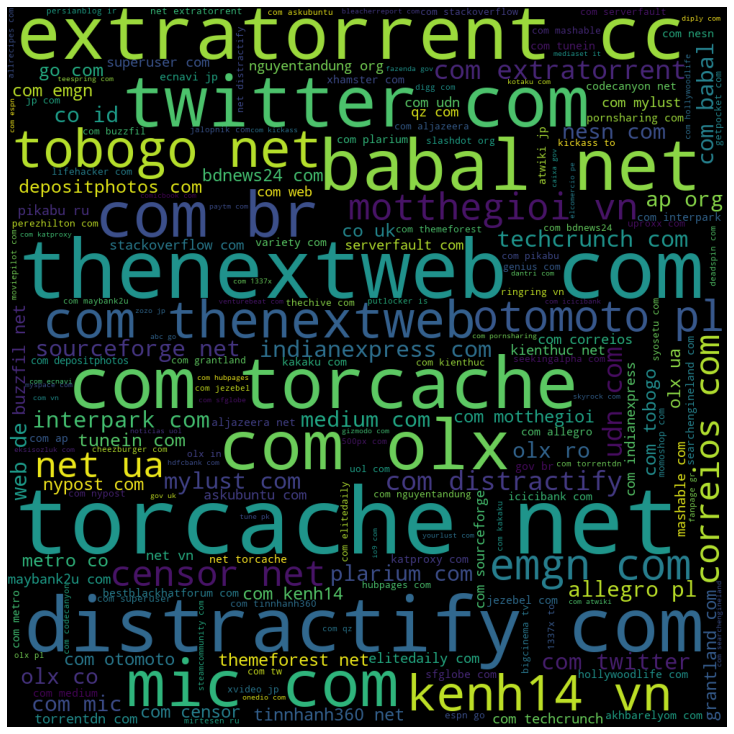

In [96]:
# Plotting wordcloud of legitimate URLs
plot_wordcloud(legitimate)

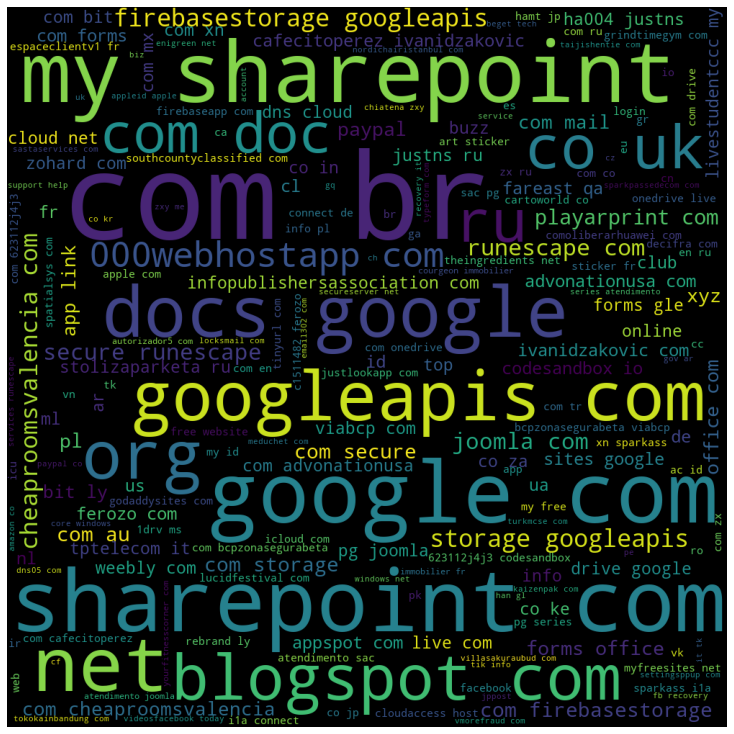

In [76]:
plot_wordcloud(phishing)

In [77]:
urldata.shape

(36716, 13)

In [78]:
urldata.to_csv('urldata.csv', index=False)


In [79]:
urldata.head()

,Domain,IP,Have@,URL_Length,URL_Depth,Redirection,https_Domain,TinyURL,Prefix/Suffix,Mouse_over,Web_forwarding,Right_click,Label
0,graphicriver.net,0,0,1,1,0,0,0,0,1,1,1,0
1,ecnavi.jp,0,0,1,1,1,0,0,0,1,1,1,0
2,hubpages.com,0,0,1,1,0,0,0,0,1,1,1,0
3,extratorrent.cc,0,0,1,3,0,0,0,0,1,1,1,0
4,icicibank.com,0,0,1,3,0,0,0,0,1,1,1,0


In [80]:
urldata.columns

Index(['Domain', 'IP', 'Have@', 'URL_Length', 'URL_Depth', 'Redirection',
       'https_Domain', 'TinyURL', 'Prefix/Suffix', 'Mouse_over',
       'Web_forwarding', 'Right_click', 'Label'],
      dtype='object')

In [81]:
urldata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36716 entries, 0 to 36715
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Domain          36716 non-null  object
 1   IP              36716 non-null  int64 
 2   Have@           36716 non-null  int64 
 3   URL_Length      36716 non-null  int64 
 4   URL_Depth       36716 non-null  int64 
 5   Redirection     36716 non-null  int64 
 6   https_Domain    36716 non-null  int64 
 7   TinyURL         36716 non-null  int64 
 8   Prefix/Suffix   36716 non-null  int64 
 9   Mouse_over      36716 non-null  int64 
 10  Web_forwarding  36716 non-null  int64 
 11  Right_click     36716 non-null  int64 
 12  Label           36716 non-null  int64 
dtypes: int64(12), object(1)
memory usage: 3.6+ MB


## Visualizing the features 

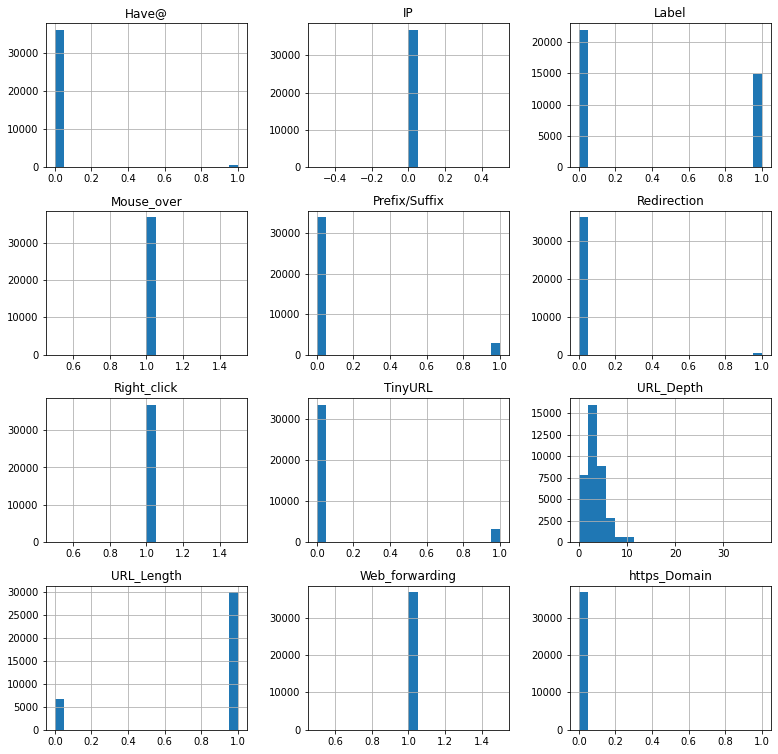

In [82]:
#Plotting the data distribution
urldata.hist(bins = 20,figsize = (13,13))
plt.show()

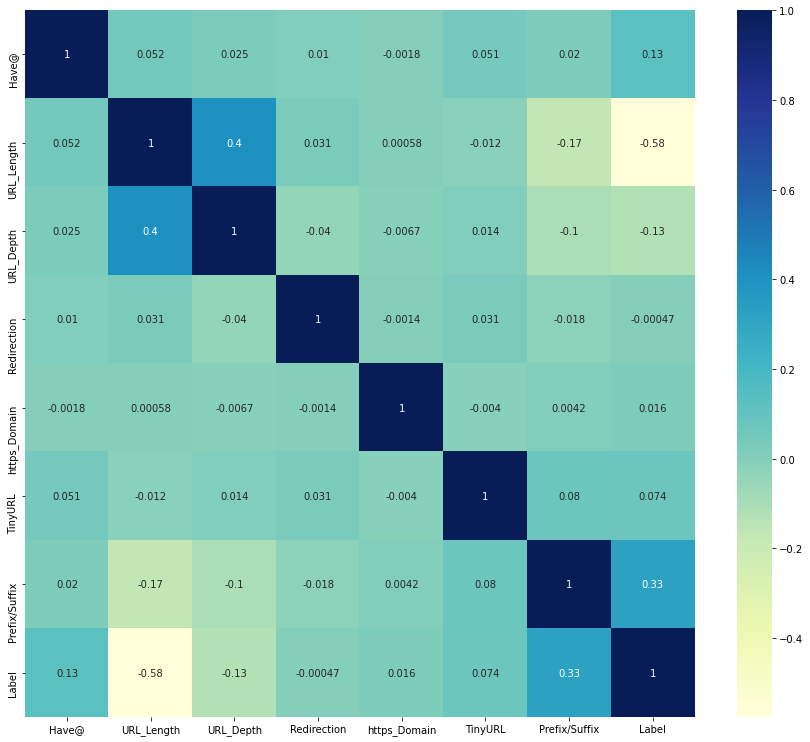

In [88]:
# correlation matrix
# matrix = np.triu(urldata.corr())

temp_df = urldata.drop(['IP','Mouse_over','Web_forwarding', 'Right_click'], axis=1)

plt.figure(figsize=(15,13))
sns.heatmap(temp_df.corr(), cmap="YlGnBu", annot=True)
plt.show()

In [89]:
urldata.describe().T

,count,mean,std,min,25%,50%,75%,max
IP,36716.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
Have@,36716.0,0.020127,0.140438,0.0,0.0,0.0,0.0,1.0
URL_Length,36716.0,0.815802,0.387651,0.0,1.0,1.0,1.0,1.0
URL_Depth,36716.0,3.106302,2.109208,0.0,2.0,3.0,4.0,38.0
Redirection,36716.0,0.012447,0.110871,0.0,0.0,0.0,0.0,1.0
https_Domain,36716.0,0.000163,0.012783,0.0,0.0,0.0,0.0,1.0
TinyURL,36716.0,0.088218,0.283615,0.0,0.0,0.0,0.0,1.0
Prefix/Suffix,36716.0,0.078140,0.268396,0.0,0.0,0.0,0.0,1.0
Mouse_over,36716.0,1.000000,0.000000,1.0,1.0,1.0,1.0,1.0
Web_forwarding,36716.0,1.000000,0.000000,1.0,1.0,1.0,1.0,1.0


In [90]:
label_count = pd.DataFrame(urldata.Label.value_counts())

In [91]:
label_count

,Label
0,21858
1,14858


<AxesSubplot:ylabel='Label'>

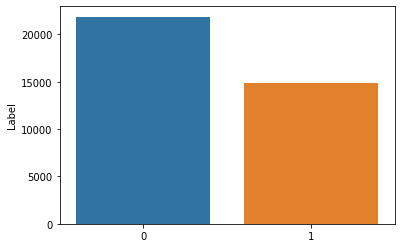

In [92]:
sns.barplot(label_count.index, label_count.Label)